<h1> <center> ENSF 519.01 Applied Data Scince </center></h1>
<h2> <center> Assignment 5: Bug Localization (25 marks)</center></h2>
<h2> <center> Due: April 13, 4pm . To be submitted on D2L Dropbox </center></h2>


In this assignment we are going to provide an automated recommendation system that given a bug report and the history of bug reports, suggest what files are likely to be buggy and need to be fixed. The general problem in software engineering domain is called Fault Localization and there are several solutions for it. Our approach will be based on TF.IDF and topic vector representations of the bug reports.


<h2> Step1: Preprocessing: Tokenizing - removing stopwords - stemming - vectorizing (7 marks)</h2>
<br><br>

Our dataset consists of a potion of Eclipse project's bug reports collected from. 

Link to Data: https://zenodo.org/record/268425#.WrVqNdPOVTZ

For each bug report the dataset have the following items: 

<ul>
<li> id: The ID which is assigned to each bug report starting from 1.
<li> bug_id: The bug report ID in the Eclipse company. 
<li> summary: A small description of bug in one line
<li> report_time: The date and time of the arrival of the bug report
<li> report_timestamp: A timeStamp assigned to each bug report when they arrive
<li> status: shows the status of bug at the time being. 
<li> commit: commit number.
<li> commit_timestamp: the commit time.
<li> files: files that have been modified to fix the bug
<li> description: The actual text of bug report. 
</ul>

We have created a clean sorted version of the last 100 bugs for you with the following features:

<ul>
<li> id: 1 is the most recent and 100 is the oldest
<li> Description 
<li> Files
</ul>

All these bugs are "Closed" bug repots (they are already fixed)

Steps: 
<ol>
<li> Read the data from XXX.csv 
<li> For each bug report in the dataset, take the Description as the document
<li> For each Document in the corpus, also keep the Files modified to fix the bug in a list, per bug. 
<li> Tokenize the Documents 
<li> Removed the stopwords from the Documents (Use SKLearn's stopword list)
<li> Stem the remaining using PorterStemmer (from nltk). 
<li> Finally, vectorize the corpus documents using CountVectorizer.
</ol>



In [14]:
import xml.etree.ElementTree as ET
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim.matutils import hellinger
import numpy as np



def readCSV(FilePath):
    
    print("Reading Data... ")
    DataFile=open(FilePath).readlines()
    BugReports=[]
    ModifiedFiles=[]
    for i,row in enumerate(DataFile):
        if i!=0:
            BugReports.append(row.split(",")[0]+" "+row.split(",")[1])
            ModifiedFiles.append(row.split(",")[2])
    return [BugReports, ModifiedFiles]


########### Tokenizing + Removing StopWords + Stemming ##############


def cleaner(text):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = get_stop_words('en')
    p_stemmer = PorterStemmer()
    tokens = tokenizer.tokenize(text)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    result=""
    for i in stopped_tokens:
        result+=p_stemmer.stem(i)+" "
    return result


########### main ##############


Data=readCSV('Eclipse_Platform_UI_100.csv')
# Data=(Data[0][:1000],Data[1][:1000])

Corpus=[]
print("Tokenizing ...\nRemoving StopWords ...\nStemming ...")
for i in range(len(Data[0])):
    stopped_stemmed_tokens=cleaner(Data[0][i])
    Corpus.append(stopped_stemmed_tokens)

print("ALL DONE!")

Reading Data... 
Tokenizing ...
Removing StopWords ...
Stemming ...
ALL DONE!


<h2> Step 2: LDA Model (10 marks)</h2>
<br><br>
In this phase, we will apply an LDA model on the corpus documents and represent them using topic membership vectors. We then use this vectors to measure similarity between a document from the test set (query) and the train set documents. Then we score the train set documents according to their similarities to the query. Finally, we identify the files relevant to the query based on the modified files from the similar bug reports.

Since the documents have timestapms (bugs come and get fixed one after the other), to evaluate our approach, the best way is to use a time series cross-validation technique from SKLearn, but for the sake of simplicity we only take one train_test_split (20 vs. 80).

Steps to follow: 
<ol>
<li> Divide the corpus into a test and train set as follows: take the 20 most recent documents as test set and the rest as the training set.
<li> Using SKLearn, build an LDA model using the Bag of Words vectors of the documents, created in the previous question (with number of topics = 100). - Note that we give the entire train and test to LDA to build a model. This is not information leaking since we are doing unsupervised decomposition here and the LDA does not uses any information that is from future.
<li> For each document in both train and the test sets, find the topic membership vector (Vector of Probability). Vector of Probability is a vector that indicates the probability of the document to be a member of each topic. Now to compare two documents, we need to compare their Vectors of Probability. 
<li> For each test set document (query document):
  <ol>
  <li>apply "Hellinger Distance" (which is a suitable distance function for Vectors with values between 0 and 1.0) to calculate it's distance to every train set document. You can import hellinger from gensim.matutils </li>
  <li>assign the inverse of Hellinger Distance per training set document as its "Similarity Score"</li>
  <li>For each file, from the list of files modified in any bug fix in the training set (provided as the "files" attribute per bug report), calculate a Score, by summing Similarity Scores of all the training set documents, in which the file is seen. </li>
  <li>rank files based on the calculated Scores. </li>
  <li>pick a cut-off Threshold and form a predicted list of files (with Threshold = 5, 10, 15, 20, 25) </li>
  <li>Calculate Precision and Recall by comparing the predicted list with the actual list of modified files per each bug report in the test set. </li>
</ol>
<li> Report median Precision and Recall over all 20 test bug report
<li> Plot the Precision and Recall for different values of threshold
</ol>


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


def Precision(ActualList,PredictionList):
    founded=0
    for actfile in list(set(ActualList.split())):
        for predFile in PredictionList:
            if str(actfile).split('/')[-1].lower() in str(predFile).lower():
                founded+=1
                break
    return float(founded/len(PredictionList))


def Recall(ActualList,PredictionList):
    founded=0
    
    for actfile in list(set(ActualList.split())):
        for predFile in PredictionList:
            if str(actfile).split('/')[-1].lower() in str(predFile).lower():
                founded+=1
                break
    return float(founded/len(ActualList.split()))

############# MAIN ################

NumberOfTopics=100


# generating BagofWords
print("generating BagofWords ...")
vect = CountVectorizer()
X = vect.fit_transform(Corpus)

# Building Model
print("Building Model ...")
lda = LatentDirichletAllocation(n_components=NumberOfTopics, learning_method="batch",max_iter=25, random_state=0)
ProbabilityVector = lda.fit_transform(X)

# SPLITTING TEST&TRAIN
print("SPLITTING TEST&TRAIN ...")

TestSize=20
TestData=(Data[0][:TestSize],Data[1][:TestSize])
TestProbabilityVector=ProbabilityVector[:TestSize]
TrainData=(Data[0][TestSize+1:],Data[1][TestSize+1:])
TrainProbabilityVector=ProbabilityVector[TestSize+1:]

# SCORING DOCS BASED ON HELLINGER DISTANCE
print("SCORING DOCS BASED ON HELLINGER DISTANCE ...")
Doc2DocSimilarities=[]
for i,testDoc in enumerate(TestData[0]):
    Similarities={}
    for j,trainDoc in enumerate(TrainData[0]):
        Similarities.update({j:1/hellinger(TrainProbabilityVector[j],TestProbabilityVector[i])})
    Doc2DocSimilarities.append(Similarities)

# Scoring Files based on Docs score
print("Scoring Files based on Docs score ...")

LDA_Thresh_Precision=np.array([])
LDA_Thresh_Recall=np.array([])

thresholds=range(5,26,5)
for THRESHOLD in thresholds:
    print("Threshold : ",THRESHOLD)     
    Doc2FileDict={}
    for i,SimilarityVec in enumerate(Doc2DocSimilarities):
        AllFiles={}
        for j,files in enumerate(TrainData[1]):
            for file in files.split():
                if file in AllFiles.keys():
                    AllFiles[file]+=SimilarityVec[j]
                else:
                    AllFiles.update({file:SimilarityVec[j]})

        AllRankedFiles = sorted(AllFiles, key=AllFiles.get, reverse=True)
        PredictedFiles=[]
        for j,file in enumerate(AllRankedFiles):
            if j<THRESHOLD:
                PredictedFiles.append(file)
        Doc2FileDict.update({i:PredictedFiles})

    # CALCULATING PRECISION&RECALL
    print("CALCULATING PRECISION&RECALL ...")
    Precisions=np.array([])
    Recalls=np.array([])
    for key,PredictionList in Doc2FileDict.items():
        precision=Precision(TestData[1][key],PredictionList)
        recall=Recall(TestData[1][key],PredictionList)
        Precisions=np.append(Precisions,precision)
        Recalls=np.append(Recalls,recall)

    print("*"*8)
#     print("\n###### Precisions:",Precisions)
    print("Median Precision: ",np.median(Precisions))
    LDA_Thresh_Precision=np.append(LDA_Thresh_Precision,np.median(Precisions))
#     print("\n######## Recalls: ",Recalls)
    print("Median Recall: ",np.median(Recalls))
    LDA_Thresh_Recall=np.append(LDA_Thresh_Recall,np.median(Recalls))



generating BagofWords ...
Building Model ...
SPLITTING TEST&TRAIN ...
SCORING DOCS BASED ON HELLINGER DISTANCE ...
Scoring Files based on Docs score ...
Threshold :  5
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.2
Median Recall:  0.065
Threshold :  10
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.1
Median Recall:  0.123333333333
Threshold :  15
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.0666666666667
Median Recall:  0.194444444444
Threshold :  20
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.05
Median Recall:  0.194444444444
Threshold :  25
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.04
Median Recall:  0.208333333333


[ 0.065       0.12333333  0.19444444  0.19444444  0.20833333]
[ 0.2         0.1         0.06666667  0.05        0.04      ]


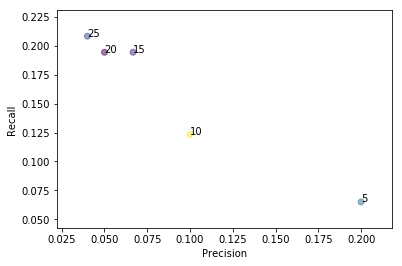

In [16]:
import matplotlib.pyplot as plt

print(LDA_Thresh_Recall)
print(LDA_Thresh_Precision)
x = LDA_Thresh_Precision
y = LDA_Thresh_Recall
colors = np.random.rand(len(LDA_Thresh_Recall))
fig, ax = plt.subplots()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
plt.scatter(x, y, c=colors, alpha=0.5)
for i,thresh in enumerate(thresholds):
    ax.annotate(str(thresh), (x[i],y[i]))
plt.show()

<h2> Step 3: TF.IDF rescaling (8 marks) </h2>
<br>In this part, we replicate the previous part but this time using a new distance function that we directly apply on TF.IDF-based representation of vectorized documents and NOT the topic memberships.  

Steps to follow: 
<ol>
<li> Using TF.IDF covert the vectorized documents from Step 1 to a matrix of doc-terms, where the cell value at (i,j) is the frequency of term j in doc i, multiplied by the idf of term j across the corpus.
<li> Now to compare two documents (two rows in the matrix) you can use Cosine Similarity measure. Since SKLearn already normalizes the TF.IDF values so that each document has a length of UNIT, you can simply take the Numpy's "Inner Product" of two rows (arrays) as their Cosine Similarity score. See https://en.wikipedia.org/wiki/Cosine_similarity for more details on the Cosine Similarity function. 
<li> After you have the Similarity Scores the rest is exactly like previous Step, at 4.C. So you basically will output the similar Precision-Recall plot.
</ol>




In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


########### main ##############

# Building TFIDF model 
print("Building TFIDF model ...")
vectorizer = TfidfVectorizer(min_df=5)
tfidf_matrix = vectorizer.fit_transform(Data[0])

# Splitting Test&Train
print("Splitting Test&Train ...")


TestSize=20
TestData=(Data[0][:TestSize],Data[1][:TestSize])
Test_tfidf_matrix=tfidf_matrix[:TestSize].toarray()
TrainData=(Data[0][TestSize+1:],Data[1][TestSize+1:])
Train_tfidf_matrix=tfidf_matrix[TestSize+1:].toarray()

# Scoring Docs based on Cosine similarity
print("Scoring Docs based on Cosin similarity ...")
Doc2DocSimilarities=[]
for i,testDoc in enumerate(TestData[0]):
    Similarities={}
    for j,trainDoc in enumerate(TrainData[0]):
        Similarities.update({j:np.inner(Test_tfidf_matrix[i],Train_tfidf_matrix[j])})
    Doc2DocSimilarities.append(Similarities)

# Scoring Files based on Docs score
print("Scoring Files based on Docs score ...")

TFIDF_Thresh_Precision=np.array([])
TFIDF_Thresh_Recall=np.array([])

thresholds=range(5,26,5)
for THRESHOLD in thresholds:
    print("Threshold : ",THRESHOLD)     
    Doc2FileDict={}
    for i,SimilarityVec in enumerate(Doc2DocSimilarities):
        AllFiles={}
        for j,files in enumerate(TrainData[1]):
            for file in files.split():
                if file in AllFiles.keys():
                    AllFiles[file]+=SimilarityVec[j]
                else:
                    AllFiles.update({file:SimilarityVec[j]})

        AllRankedFiles = sorted(AllFiles, key=AllFiles.get, reverse=True)
        PredictedFiles=[]
        for j,file in enumerate(AllRankedFiles):
            if j<THRESHOLD:
                PredictedFiles.append(file)
        Doc2FileDict.update({i:PredictedFiles})

    # CALCULATING PRECISION&RECALL
    print("CALCULATING PRECISION&RECALL ...")
    Precisions=np.array([])
    Recalls=np.array([])
    for key,PredictionList in Doc2FileDict.items():
        precision=Precision(TestData[1][key],PredictionList)
        recall=Recall(TestData[1][key],PredictionList)
        Precisions=np.append(Precisions,precision)
        Recalls=np.append(Recalls,recall)


    print("*"*8)
#     print("\n###### Precisions:",Precisions)
    print("Median Precision: ",np.median(Precisions))
    TFIDF_Thresh_Precision=np.append(TFIDF_Thresh_Precision,np.median(Precisions))
#     print("\n######## Recalls: ",Recalls)
    print("Median Recall: ",np.median(Recalls))
    TFIDF_Thresh_Recall=np.append(TFIDF_Thresh_Recall,np.median(Recalls))




Building TFIDF model ...
Splitting Test&Train ...
Scoring Docs based on Cosin similarity ...
Scoring Files based on Docs score ...
Threshold :  5
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.2
Median Recall:  0.065
Threshold :  10
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.1
Median Recall:  0.075
Threshold :  15
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.0666666666667
Median Recall:  0.085
Threshold :  20
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.05
Median Recall:  0.185
Threshold :  25
CALCULATING PRECISION&RECALL ...
********
Median Precision:  0.04
Median Recall:  0.1875


[ 0.065   0.075   0.085   0.185   0.1875]
[ 0.2         0.1         0.06666667  0.05        0.04      ]


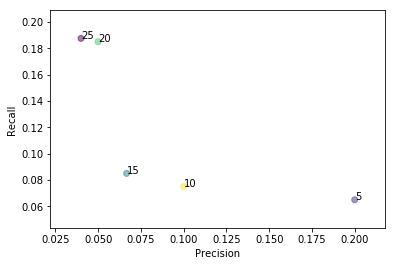

In [18]:
import matplotlib.pyplot as plt

print(TFIDF_Thresh_Recall)
print(TFIDF_Thresh_Precision)
x = TFIDF_Thresh_Precision
y = TFIDF_Thresh_Recall
colors = np.random.rand(len(TFIDF_Thresh_Recall))
fig, ax = plt.subplots()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
plt.scatter(x, y, c=colors, alpha=0.5)
for i,thresh in enumerate(thresholds):
    ax.annotate(str(thresh), (x[i],y[i]))
plt.show()